**Attributions**

The below code uses the template from the [Bayesian Switchpoint Analysis](https://www.tensorflow.org/probability/examples/Bayesian_Switchpoint_Analysis#prerequisites) tutorial, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license.

Modifications have been made to the below code for the purpose of generating appropriate analyses on the Brexit time series dataset - the original dataset used was the [UK coal mining disaster time series](https://pymc-devs.github.io/pymc/tutorial.html#two-types-of-variables). The original source code can be found [here](https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Switchpoint_Analysis.ipynb).

##### Copyright 2019 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bayesian Switchpoint Analysis

In [2]:
# Data source: https://pageviews.toolforge.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2019-06-13&end=2020-07-03&pages=Brexit## Prerequisites

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd

In [3]:
train_df = pd.read_csv("pageviews-20190613-20200703.csv")

In [4]:
tseries=train_df['ln_brexit']
tseries

0      8.992557
1      8.726319
2      8.538563
3      8.718337
4      8.846929
         ...   
382    8.190354
383    8.439880
384    8.394347
385    8.200288
386    8.058644
Name: ln_brexit, Length: 387, dtype: float64

In [5]:
brexit_data = np.array(tseries)

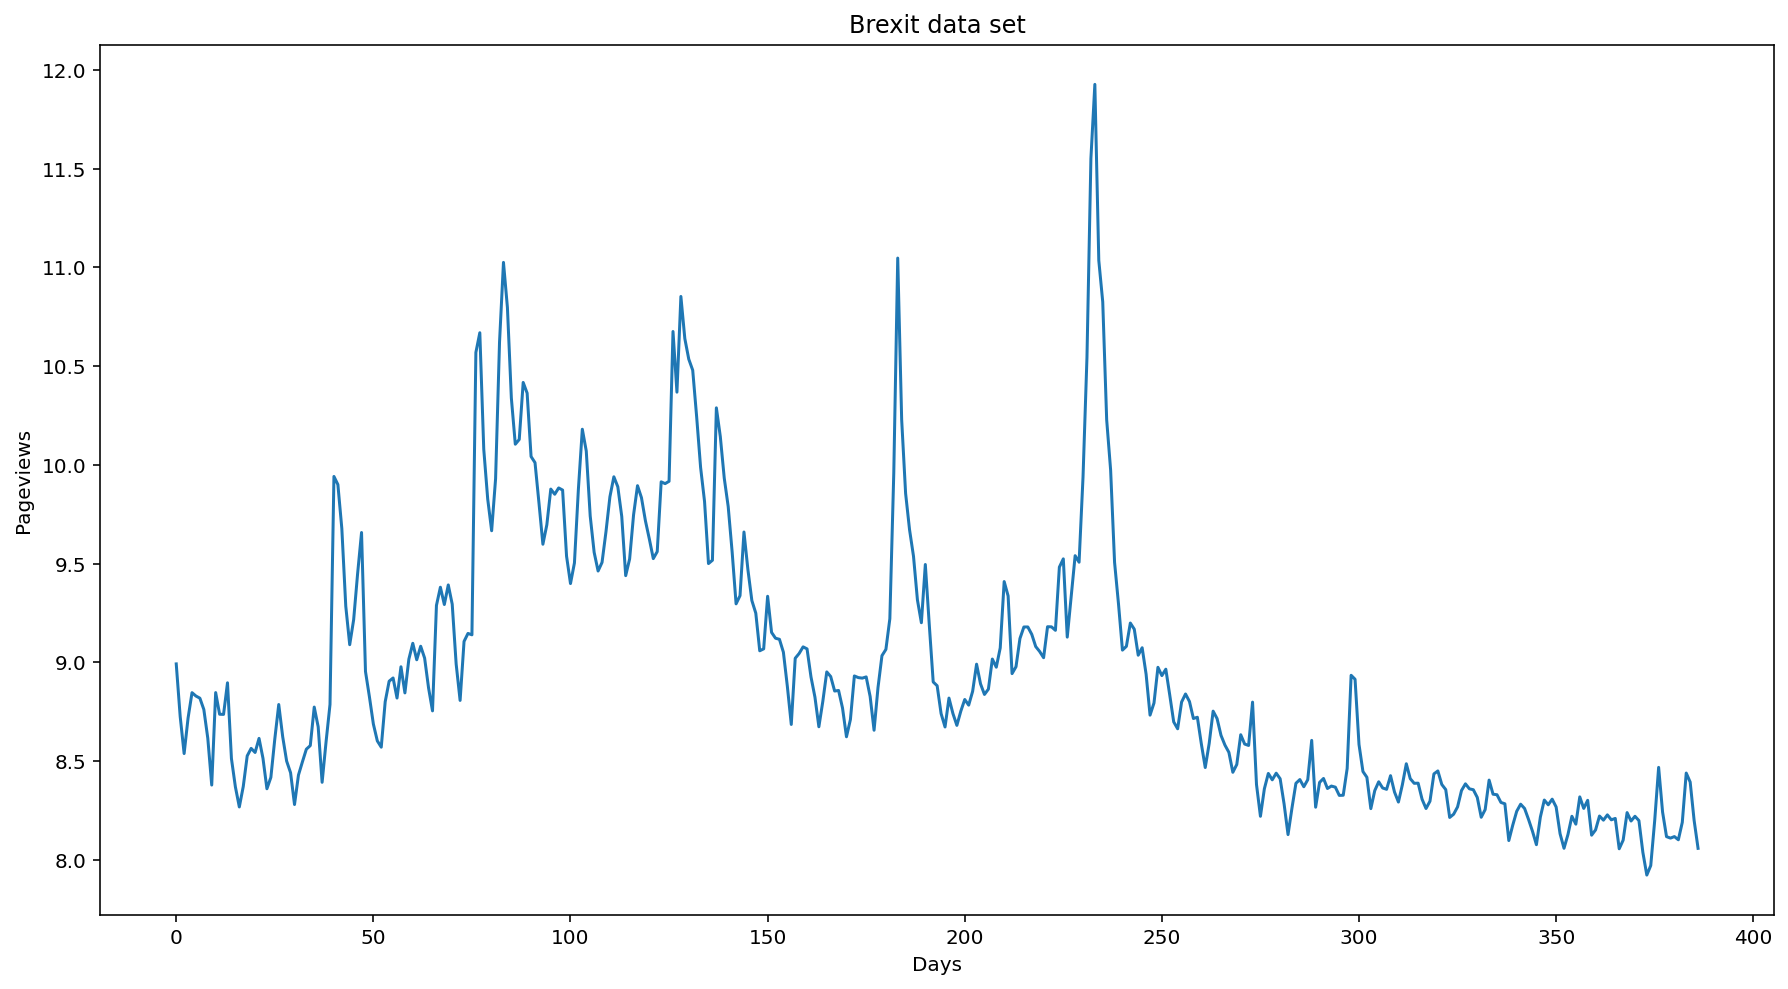

In [6]:
date=np.arange(0,387)
plt.plot(brexit_data)
plt.ylabel('Pageviews')
plt.xlabel('Days')
plt.title('Brexit data set')
plt.show()

In [7]:
def brexit_count_model(brexit_rate_fn):
  brexit_count = tfd.JointDistributionNamed(dict(
    e=tfd.Exponential(rate=1.),
    l=tfd.Exponential(rate=1.),
    s=tfd.Uniform(0., high=len(date)),
    d_t=lambda s, l, e: tfd.Independent(
        tfd.Poisson(rate=brexit_rate_fn(np.arange(len(date)), s, l, e)),
        reinterpreted_batch_ndims=1)
  ))
  return brexit_count

def brexit_rate_switch(ys, s, l, e):
  return tf.where(ys < s, e, l)

def brexit_rate_sigmoid(ys, s, l, e):
  return e + tf.sigmoid(ys - s) * (l - e)

model_switch = brexit_count_model(brexit_rate_switch)
model_sigmoid = brexit_count_model(brexit_rate_sigmoid)

In [8]:
def target_log_prob_fn(model, s, e, l):
  return model.log_prob(s=s, e=e, l=l, d_t=brexit_data)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-5333.457, -5321.0854]
[-1905.2054, -1898.9205]
[-inf, -inf]


In [9]:
num_results = 10000
num_burnin_steps = 3000

@tf.function(autograph=False, experimental_compile=True)
def make_chain(target_log_prob_fn):
   kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          tfb.Sigmoid(low=0., high=tf.cast(len(date), dtype=tf.float32)),
          tfb.Softplus(),
          tfb.Softplus(),
      ])
   kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

   states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_pre_covid_rate'),
          tf.ones([], name='init_post_covid_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
   return states

switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, pre_covid_rate, post_covid_rate = zip(
    switch_samples, sigmoid_samples)

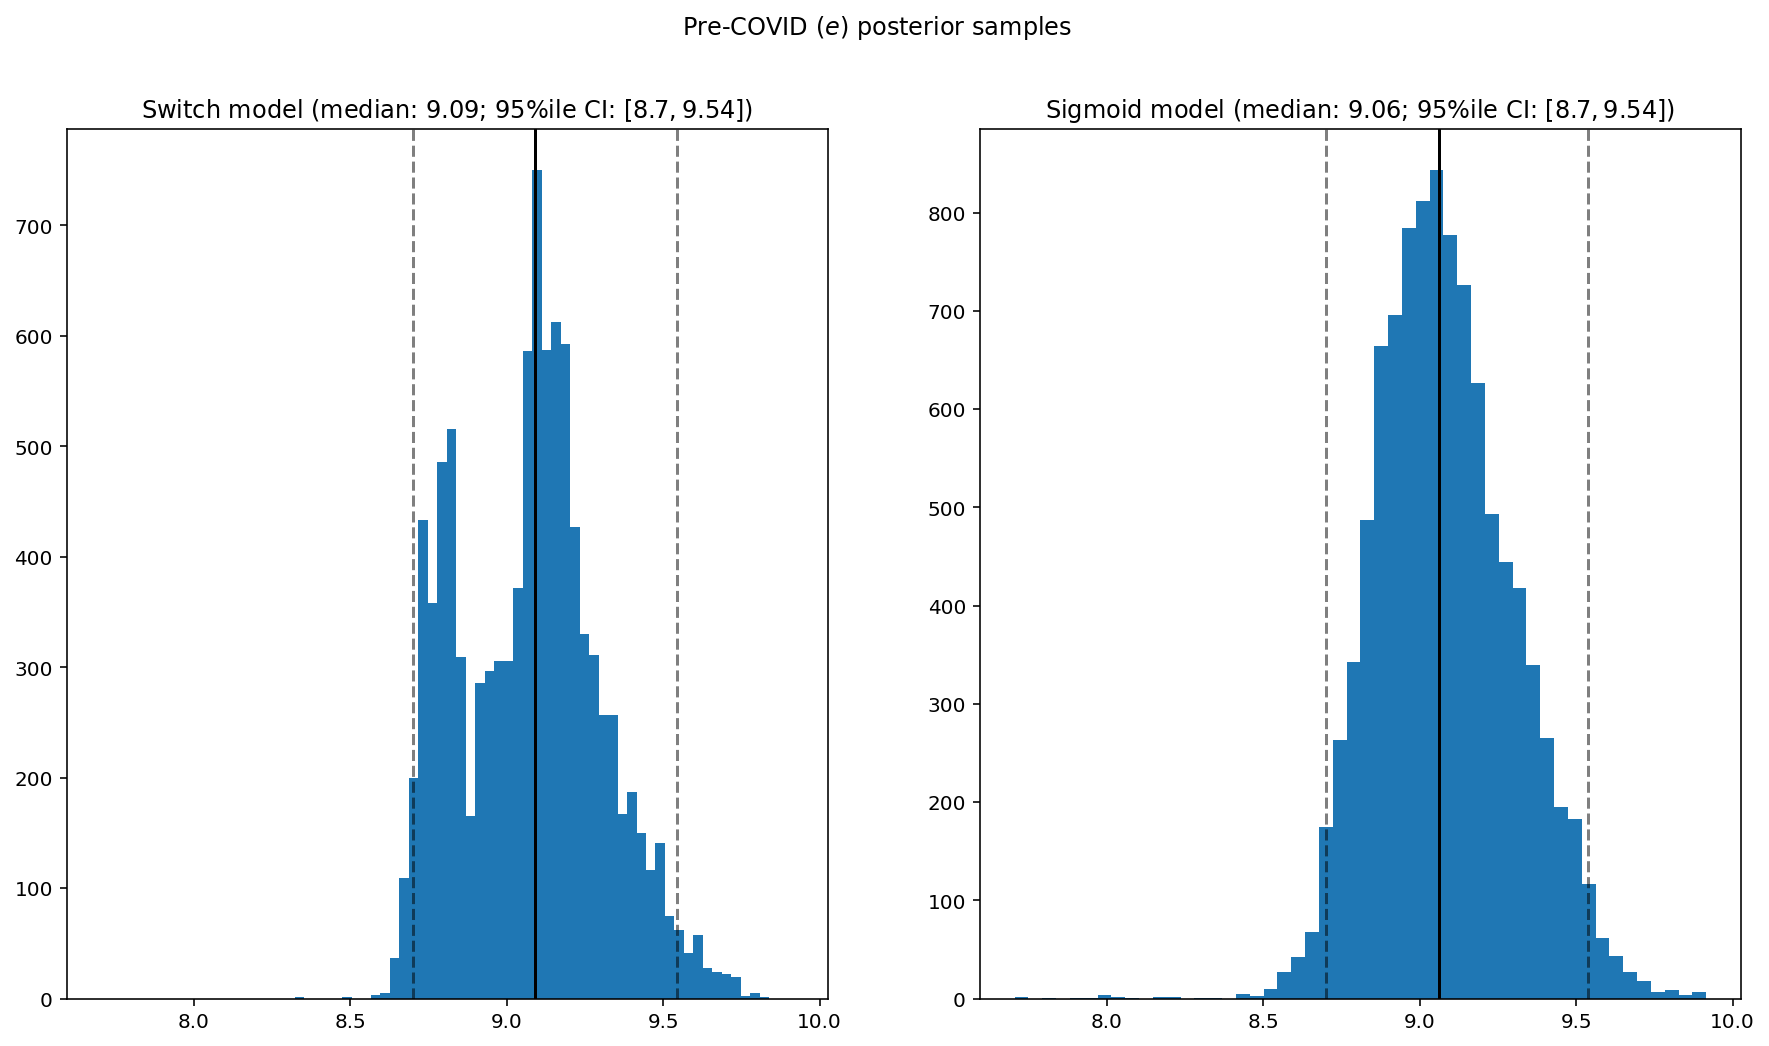

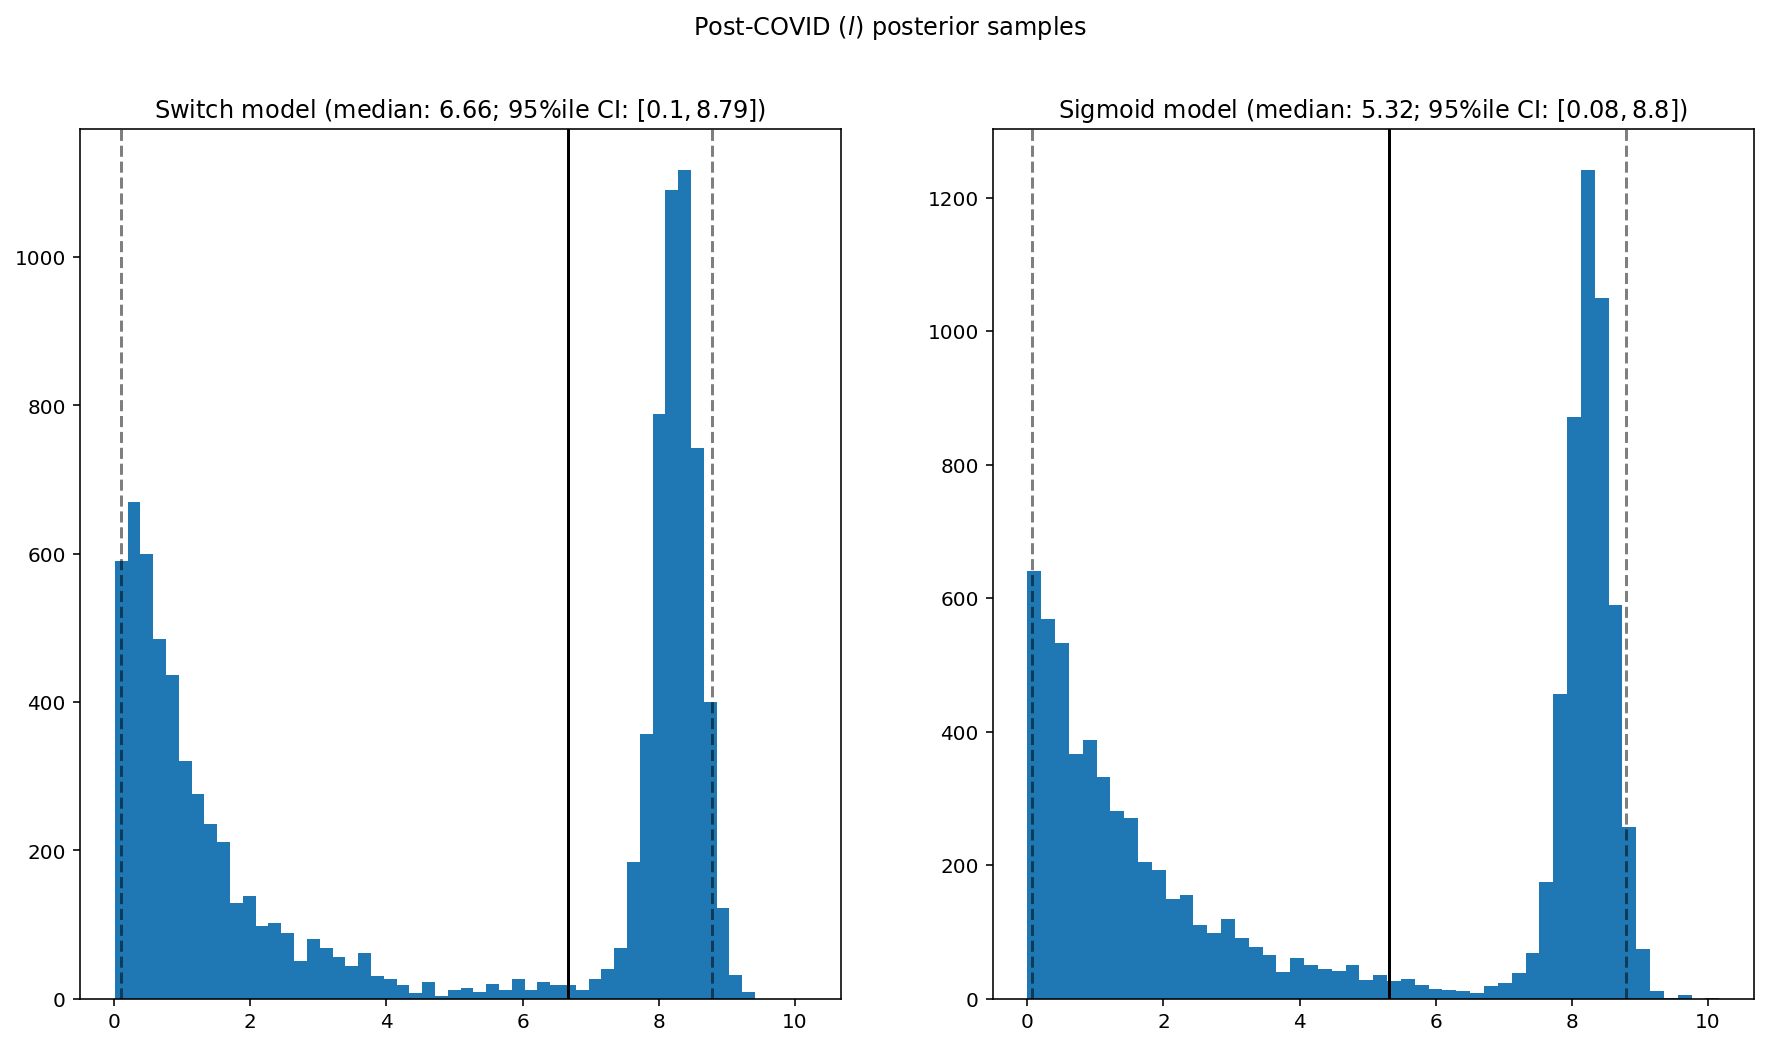

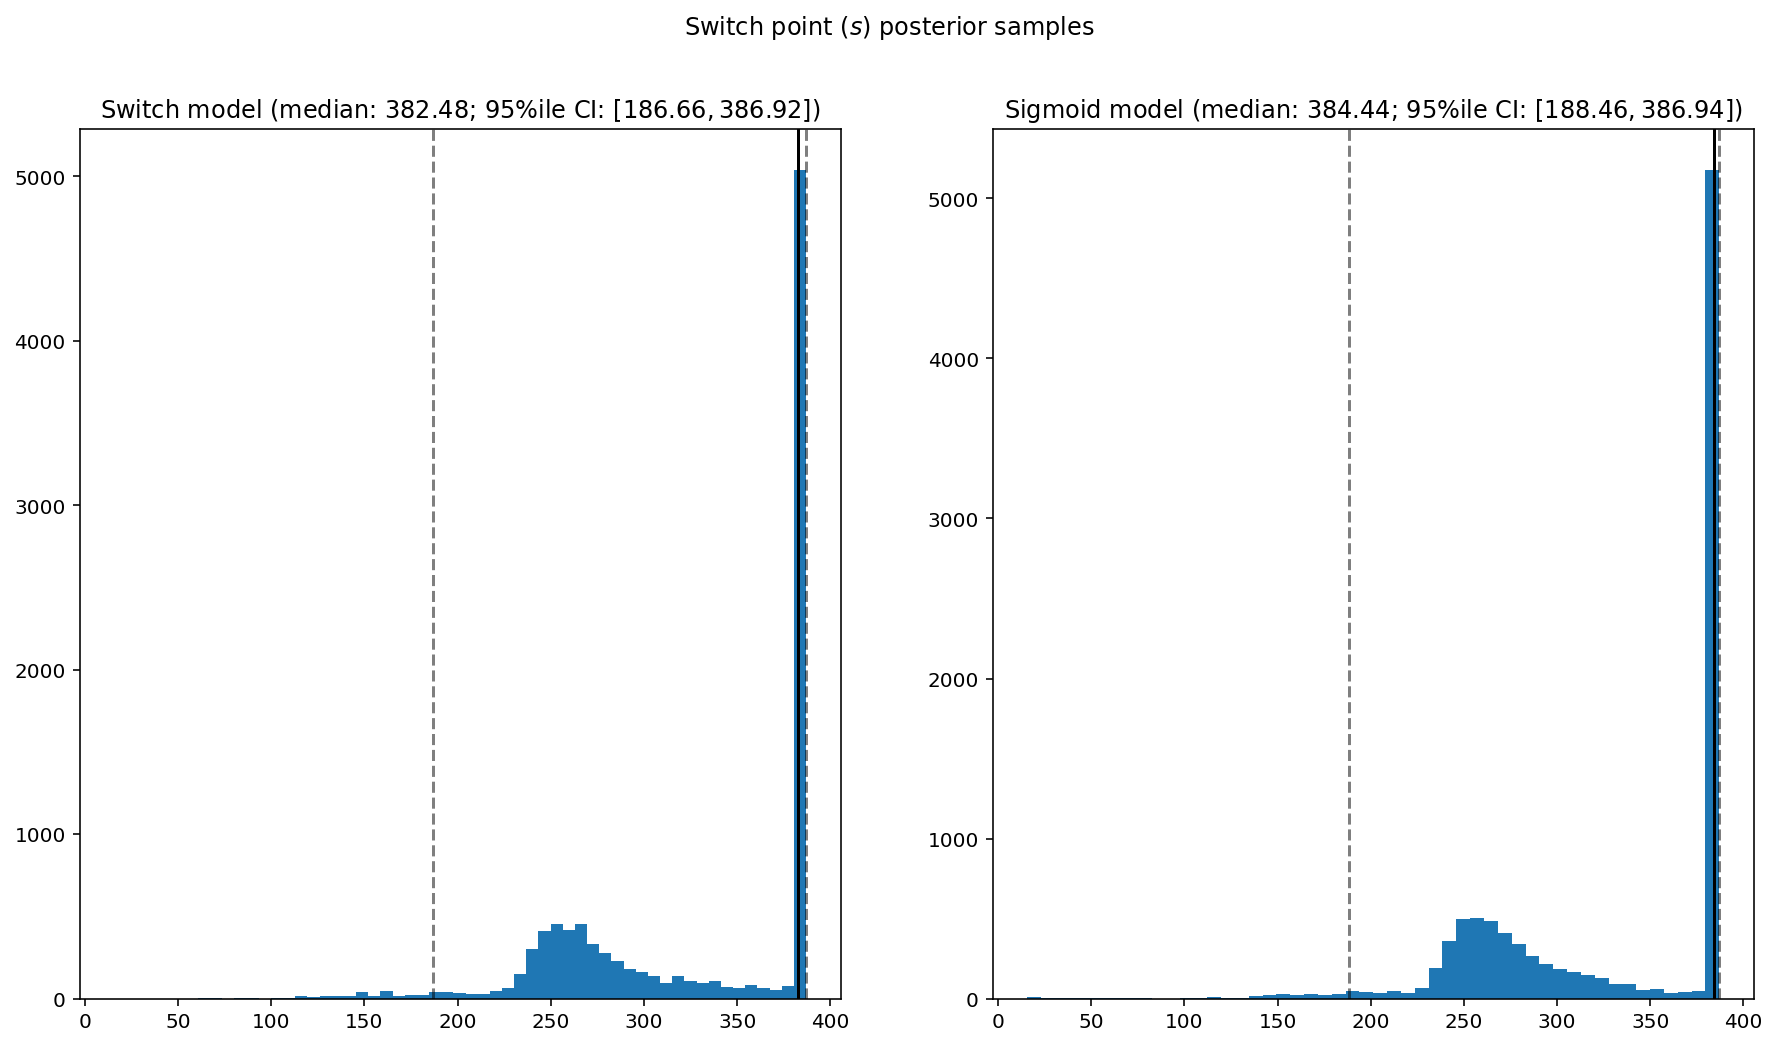

In [10]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Pre-COVID ($e$) posterior samples', pre_covid_rate),
    ('Post-COVID ($l$) posterior samples', post_covid_rate),
    ('Switch point ($s$) posterior samples', date[0] + switchpoint),
]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()